# Failure Mode Demonstration Notebook

A notebook to demonstrate some of the features of the Failure Mode class

Author: gavin.treseder@essentialenergy.com.au

In [1]:
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *
import pof.demo as demo

fm = FailureMode().set_demo()

Error loading FailureMode data


## Single timeline
Generate a single timeline to show the state of the failure mode, its condition and the days until a task is triggered over time.

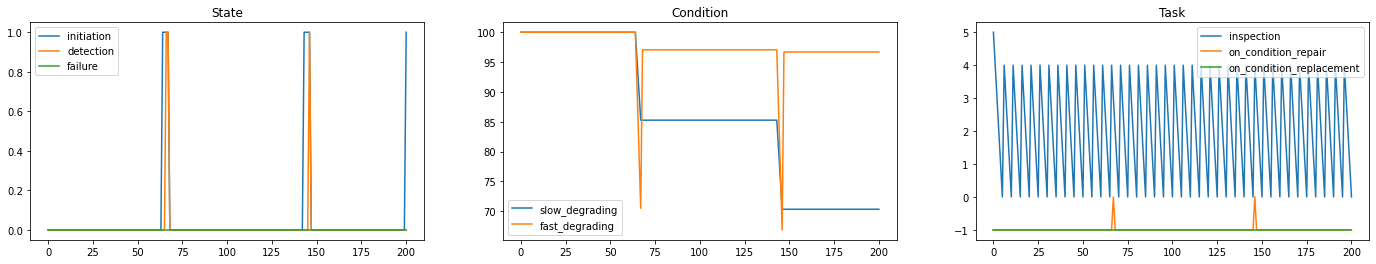

In [5]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

The simulation above assumes that the failure mode is in perfect condition while the simulation below starts with some accumulated damage.

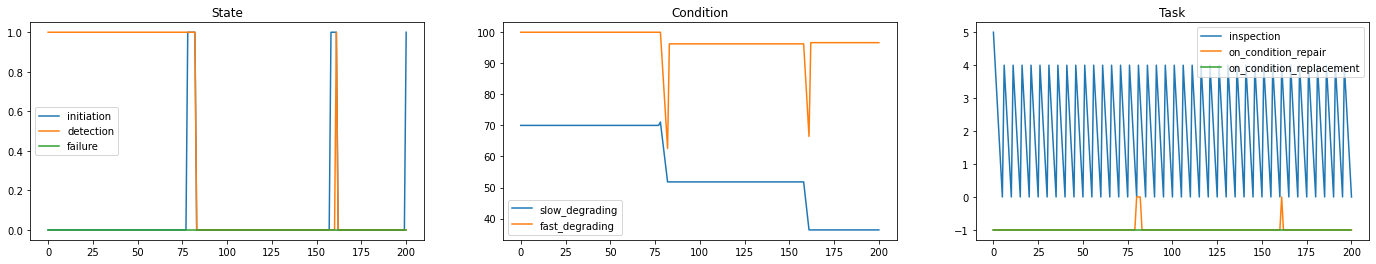

In [4]:
fm._initiated = True
fm.conditions['slow_degrading'].set_condition(70)
fm.sim_timeline(200)
fm.plot_timeline()

## Maintenance Strategy

The maintenance strategy...

In [5]:
fm = FailureMode().set_demo()

fm.mc_timeline(t_end=200, n_iterations=1000)

df = fm.expected_risk_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


In [6]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI     Upper CI
Parameter                                                         
Alpha          913.419298      213.699360  577.466774  1444.818735
Beta             1.506197        0.184067    1.185385     1.913834
Gamma           46.553065       10.229872   30.262148    71.613816
Log-Likelihood: -571.0140388868822


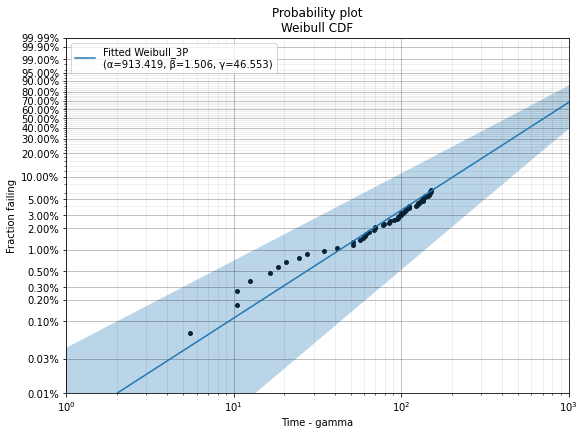

In [7]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored);

## Condition

In [20]:
from pof.interface.figures import update_condition_fig

update_condition

In [22]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm._expected_cost()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:07<00:00, 126.12it/s]


In [23]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [14]:
fm.mc_timeline(1000)

df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


In [15]:
test = np.array([True, True, True, False])

test.mean()

0.75

In [16]:
%%timeit
t_end = 200
t_start=0
n_iterations=100

fm.reset()  # TODO ditch this

for i in tqdm(range(n_iterations)):
    fm._timelines[i] = fm.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 100/100 [00:02<00:00, 47.39it/s]1.88 s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [17]:
%%timeit
t_end = 200
t_start=0
n_iterations=100

fm.reset()  # TODO ditch this

for i in tqdm(range(n_iterations)):
    fm._timelines[i] = fm.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 100/100 [00:01<00:00, 66.46it/s]2.06 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

